# TIPS-Treasury Arbitrage Replication (2010-2020)

This notebook replicates the TIPS–Treasury arbitrage strategy for the period 2010–2020 following the methodology of Fleckenstein et al. (2014). It also outlines how a trader could implement this strategy in practice.

## Methods

### Replication Strategy

1. **Data Sources**:
   - **TIPS Data:** Daily yield data for TIPS from U.S. Treasury sources.
   - **Inflation Swap Data:** Zero-coupon inflation swap rates from Bloomberg.
   - **Nominal Treasury Data:** Daily nominal Treasury yields from CRSP.

2. **Synthetic Yield Construction:**

   For a given maturity \(\tau\):

   \begin{equation}
   \text{Synthetic Yield}_{t,\tau} = s_{t,\tau} + f_{t,\tau}
   \end{equation}

   where \(s_{t,\tau}\) is the TIPS yield and \(f_{t,\tau}\) is the fixed rate from the inflation swap. The arbitrage spread is then:

   \begin{equation}
   \text{Spread}_{t,\tau} = (s_{t,\tau} + f_{t,\tau}) - y_{T,t,\tau}
   \end{equation}

   A positive spread indicates that nominal Treasuries are overpriced relative to the synthetic yield.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="dark")

### Load Data

The following cell loads the TIPS-Treasury arbitrage data from a parquet file. This file is generated from `compute_tips_treasury.py`. This formulates a tidy set of the data.

- Columns starting with "real_": TIPS real yields for each tenor (e.g., real_cc2, real_cc5, real_cc10, real_cc20)
expressed in decimal form (e.g., 0.02 for 2%).
- Columns starting with "nom_": Computed nominal zero-coupon Treasury yields for each tenor
(e.g., nom_zc2, nom_zc5, nom_zc10, nom_zc20) expressed in basis points.
- Columns starting with "tips_": TIPS-implied risk-free rates (e.g., tips_treas_2_rf, tips_treas_5_rf,
tips_treas_10_rf, tips_treas_20_rf) expressed in basis points.
- Columns starting with "arb_": Arbitrage measures (e.g., arb_2, arb_5, arb_10, arb_20) representing the
difference between the TIPS-implied risk-free rate and the corresponding nominal yield (tips_treas_{t}_rf - nom_zc{t}).


In [4]:
rf = pd.read_parquet("../_data/tips_treasury_implied_rf.parquet")
rf

,date,real_cc2,real_cc5,real_cc10,real_cc20,nom_zc2,nom_zc5,nom_zc10,nom_zc20,tips_treas_2_rf,tips_treas_5_rf,tips_treas_10_rf,tips_treas_20_rf,arb_2,arb_5,arb_10,arb_20
0,2010-01-04,-0.000515,0.007010,0.016359,0.021538,109.505229,268.439780,428.047942,500.008760,153.039838,306.999411,451.983024,532.350304,43.534609,38.559630,23.935082,32.341544
1,2010-01-05,-0.001248,0.006286,0.015905,0.020813,101.824926,259.540905,420.521627,494.245870,141.315737,299.288270,442.961403,519.622174,39.490811,39.747365,22.439776,25.376304
2,2010-01-06,-0.001413,0.006443,0.016328,0.021353,102.875564,264.569315,428.767485,504.808368,141.220328,301.156999,448.589298,522.995516,38.344764,36.587685,19.821813,18.187148
3,2010-01-07,-0.002250,0.006208,0.015919,0.021503,104.805405,266.283644,427.808072,503.820974,135.279947,304.270766,449.478216,529.948426,30.474542,37.987122,21.670143,26.127452
4,2010-01-08,-0.002142,0.005842,0.015771,0.021135,98.996805,262.434519,426.160609,503.243297,139.807254,295.420505,449.008662,527.769585,40.810449,32.985986,22.848053,24.526288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887,2024-12-24,0.019212,0.020855,0.022503,0.024221,440.120171,451.945078,472.356728,497.950976,455.605814,463.373977,481.859136,496.573273,15.485643,11.428899,9.502408,-1.377703
3888,2024-12-26,0.019155,0.020751,0.022394,0.024151,438.575147,449.426463,470.817405,498.181934,453.633753,461.060676,480.236030,495.613164,15.058606,11.634213,9.418625,-2.568769
3889,2024-12-27,0.019295,0.021138,0.022898,0.024698,438.387255,452.206380,475.876031,504.031050,454.067681,464.946482,486.235616,502.278329,15.680426,12.740102,10.359584,-1.752720
3890,2024-12-30,0.018824,0.020605,0.022550,0.024555,431.489761,443.200460,467.823179,499.725280,446.200063,456.246432,478.833361,497.220339,14.710303,13.045971,11.010182,-2.504941


Selected region

In [5]:
test = pd.DataFrame(index=rf.index)
test = rf[['arb_2', 'arb_5', 'arb_10', 'arb_20']]
test['date'] = rf['date']
test.index = test['date']
test.drop('date', axis=1, inplace=True)
test

,arb_2,arb_5,arb_10,arb_20
date,,,,
2010-01-04,43.534609,38.559630,23.935082,32.341544
2010-01-05,39.490811,39.747365,22.439776,25.376304
2010-01-06,38.344764,36.587685,19.821813,18.187148
2010-01-07,30.474542,37.987122,21.670143,26.127452
2010-01-08,40.810449,32.985986,22.848053,24.526288
...,...,...,...,...
2024-12-24,15.485643,11.428899,9.502408,-1.377703
2024-12-26,15.058606,11.634213,9.418625,-2.568769
2024-12-27,15.680426,12.740102,10.359584,-1.752720


### Generate Summary Statistics

The cell below computes summary statistics using `generate_figures.py` for each TIPS-Treasury arbitrage series over the period 2010-2020.

In [6]:
import statsmodels.api as sm
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import generate_figures

# Compute summary statistics for the period 2010-01-01 to 2020-02-28
summary_stats = generate_figures.generate_summary_statistics(test, '2010-01-01', '2020-02-28')
summary_stats

,Mean,p50,Std. Dev,Min,Max,AR1,First,Last,N
TIPS-Treasury 2Y,20,23,14,0,54,0.978,Jan-2010,Feb-2020,2506
TIPS-Treasury 5Y,19,20,8,0,56,0.981,Jan-2010,Feb-2020,2541
TIPS-Treasury 10Y,25,25,7,0,40,0.976,Jan-2010,Feb-2020,2541
TIPS-Treasury 20Y,26,26,8,1,47,0.974,Jan-2010,Feb-2020,2541


### Plot TIPS-Treasury Spreads

The following cell plots the arbitrage spreads for various maturities (2Y, 5Y, 10Y, 20Y) over the period 2010-2020.

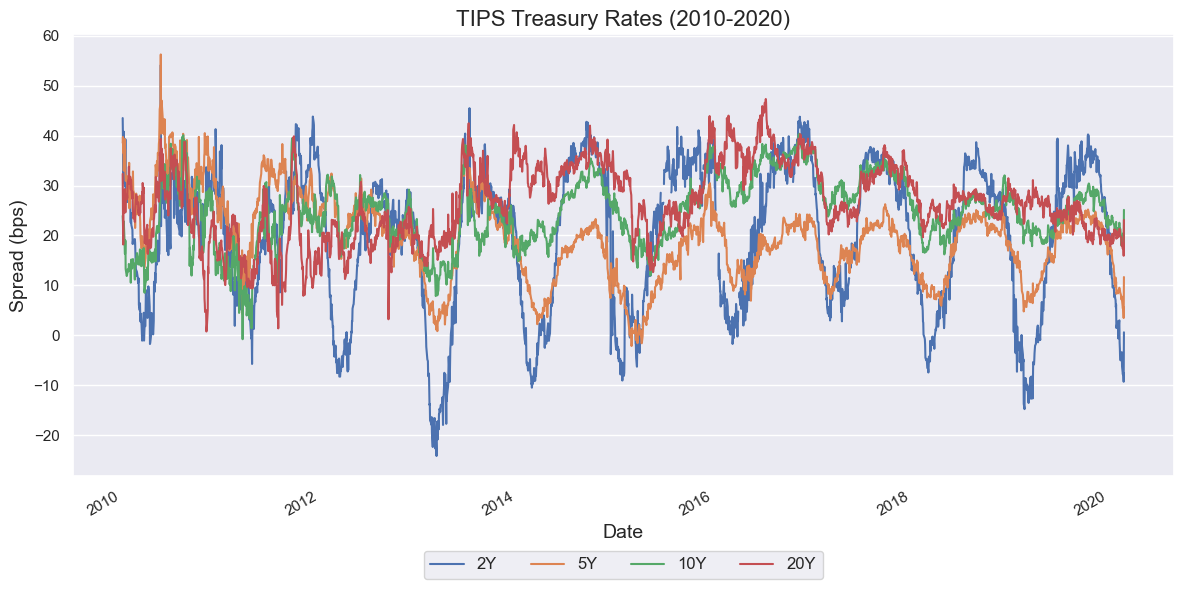

In [8]:
fig = generate_figures.plot_tips_treasury_spreads(test, '2010-01-01', '2020-02-28')
plt.show()

### Practical Implementation

A trader could use the following steps to exploit the arbitrage opportunity:

1. **Signal Identification:** Continuously monitor the arbitrage spread using updated TIPS, inflation swap, and Treasury data. A consistently positive spread signals an opportunity.

2. **Position Construction:**
   - **Long Position:** Purchase TIPS and enter into corresponding zero-coupon inflation swap contracts to convert the real cash flows into fixed nominal cash flows.
   - **Short Position:** Short the nominal Treasury bond (or use Treasury futures/repurchase agreements as a proxy).

3. **Cash Flow Matching:** Utilize Treasury STRIPS or additional derivatives to ensure that the cash flows from the long and short positions align, thereby locking in the arbitrage profit.

4. **Risk Management:** Monitor execution costs, margin requirements, and liquidity risks. Funding constraints and counterparty risks must also be managed.

This strategy, while theoretically risk-free, requires meticulous execution and risk management in practice.

## Conclusion

The analysis confirms that a positive TIPS-Treasury arbitrage spread persisted throughout 2010–2020. Although the magnitude of the mispricing is lower than during the earlier period covered by Fleckenstein et al. (2014), the spread remains statistically and economically significant. This persistence underscores the impact of market frictions and funding constraints on arbitrage opportunities. In practice, traders could exploit this anomaly by constructing synthetic nominal positions using TIPS, inflation swaps, and nominal Treasury bonds, while carefully managing execution and funding risks.